# Pretrained Model
### The reason that it is introduced
* [ILSCVRC](http://image-net.org/)에서 1000개의 클래스를 classification하는 문제를 solving한 모델이 있다.
* 이모델은 1000개를 분류할 수 있는 능력이 있지만 수백만장의 이미지 데이터를 다시 트레이닝하는 것은 매우 무리다.
* 그래서 연구소에서는 이모델을 open source로 제공하는 방향으로 연구를 하고 이를 우리는 사용해 좋은 **visual features **를 이용할 수 있게 되었다.
* 사용법은 매우 간단하다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
transform_train = transforms.Compose(
    [transforms.RandomResizedCrop(224), # data augmentation, 224: image size, ImageNet pretrained model에 맞추기 위해서 224 size로 설정
     transforms.RandomHorizontalFlip(), # data augmentation, 좌우로 대칭
     transforms.ToTensor(), # numpy array를 pytorch tensor로 바꿔주는 역할
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # dataset의 mean, std를 이용해서 -1~1 로 normalize
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### TO DO - Load and Define pretrained model and fine-tuning
- Use torchvision.models.resnet18
- Re-define the last fully connected layer for our task (ImageNet Dataset: 1000 classes, CIFAR10 Dataset: 10 classes, so set the last fully connected layer's out_features to 10) 

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [6]:
print(models.resnet18())
print('--------------')
print(models.resnet18().fc)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# resnet_cls = models.resnet18(pretrained=True)
class ResNet18(nn.Module):
    def __init__ (self):
        super(ResNet18, self).__init__()
        # TODO
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        x = self.resnet(x) # batch_size * 10
        return x
        

## Load Model

In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = ResNet18()
net = net.to(device)

cuda


## Training

In [10]:
training_epochs = 15
learning_rate = 0.01

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9)
net.train()

j = 0
for epoch in range(training_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = net(inputs) 
        loss =  criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        j += 1
        
print('Finished Training')

[1,   100] loss: 1.466
[1,   200] loss: 1.120
[1,   300] loss: 0.935
[1,   400] loss: 0.851
[1,   500] loss: 0.853
[1,   600] loss: 0.785
[1,   700] loss: 0.782
[2,   100] loss: 0.722
[2,   200] loss: 0.732
[2,   300] loss: 0.677
[2,   400] loss: 0.681
[2,   500] loss: 0.676
[2,   600] loss: 0.688
[2,   700] loss: 0.675
[3,   100] loss: 0.650
[3,   200] loss: 0.629
[3,   300] loss: 0.610
[3,   400] loss: 0.604
[3,   500] loss: 0.588
[3,   600] loss: 0.584
[3,   700] loss: 0.579
[4,   100] loss: 0.560
[4,   200] loss: 0.564
[4,   300] loss: 0.553
[4,   400] loss: 0.564
[4,   500] loss: 0.581
[4,   600] loss: 0.578
[4,   700] loss: 0.561
[5,   100] loss: 0.516
[5,   200] loss: 0.528
[5,   300] loss: 0.524
[5,   400] loss: 0.540
[5,   500] loss: 0.501
[5,   600] loss: 0.535
[5,   700] loss: 0.514
[6,   100] loss: 0.528
[6,   200] loss: 0.513
[6,   300] loss: 0.483
[6,   400] loss: 0.490
[6,   500] loss: 0.464
[6,   600] loss: 0.511
[6,   700] loss: 0.507
[7,   100] loss: 0.464
[7,   200] 

## Test

In [11]:
class_correct = np.zeros(10)
class_total = np.zeros(10)

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('Mean Accuracy : ', 100*np.sum(class_correct)/np.sum(class_total))

Accuracy of plane : 87.200000 %
Accuracy of   car : 86.700000 %
Accuracy of  bird : 79.400000 %
Accuracy of   cat : 65.600000 %
Accuracy of  deer : 82.100000 %
Accuracy of   dog : 85.000000 %
Accuracy of  frog : 91.000000 %
Accuracy of horse : 82.600000 %
Accuracy of  ship : 87.000000 %
Accuracy of truck : 91.200000 %
Mean Accuracy :  83.78


## Visualization

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
# Get a batch of training data
dataiter = iter(testloader)

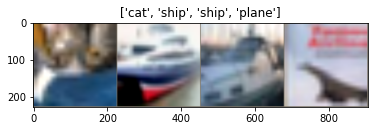

In [13]:
inputs, labels = dataiter.next()
outputs = net(inputs.cuda())
_, predicted = torch.max(outputs.data, 1)
imshow(torchvision.utils.make_grid(inputs), title=[classes[x] for x in predicted])